## 8.뉴스 요약봇 만들기 (Final Project)

### 프로젝트의 목적 및 루브릭: 새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해본다.

- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
- 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## 추상적 요약

In [2]:
# 필요한 모듈 import

import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from attention import AttentionLayer
from tensorflow.keras.layers import AdditiveAttention

import urllib.request

In [3]:
# 불용어 사전 다운로드

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# 자료 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
# 데이터 전체 구성 확인, 요약문인 headline과 본문인 text로 구성되어 있다. 
# 총 98401행으로 구성

data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습
- 추출적 요약을 하는 경우에는 오직 text열만 사용

In [6]:
# text 내용 확인

data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [7]:
# 데이터 중복검사
# 설마 문장 전체가 똑같은 중복이 있을까해서 검사 해보았는데 있네 ㅡㅡ;;;;

print('Text열의 유일한 샘플 수:', data['text'].nunique())
print('Headline열의 유일한 샘플 수:', data['headlines'].nunique())

Text열의 유일한 샘플 수: 98360
Headline열의 유일한 샘플 수: 98280


In [8]:
# drop_duplicates()를 이용하여 중복 샘플을 제거하자

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [9]:
# .value_counts()를 사용하여 중복 샘플 수 한번 더 확인 사살
# 없는 것으로 나온다.

print('중복 샘플수:', data['text'].value_counts())

중복 샘플수: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.                   1
BJP leader Shahnawaz Hussain has said that Congress Vice President Rahul Gandhi is afraid of Union Minister Smriti Irani's name and other female BJP leaders. Reacting to Gandhi's claims that "BJP's thinking is that till women are silent they are good", Hussain said, "Rahul will take time to understand BJP and RSS... he will have to do research for it."                                        1
A fire broke out on Friday at a landfill in Delhi's Ghazipur and five fire engines were rushed to the spot to contain it. Earlier in September, two people died when a portion of the garbage dump colla

In [10]:
# 결측치 확인, 확인결과 결측치 없음

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [12]:
# 불용어
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [13]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [14]:
# Text 전처리
clean_text = []

# 전체 Text 데이터에 대한 전처리
# preprocess_sentence()함수를 사용해서 전처리 진행하고 차례대로 clean_text에 집어 넣는다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

# Summary 전처리
clean_summary = []

# 전체 Summary 데이터에 대한 전처리
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [15]:
# DataFrame에 재저장
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# null 확인
data.isnull().sum()

# null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data))) #데이터 전처리 함수

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 표준편차 : 3.7993861876499637
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534
요약의 표준편차 : 1.3900944321771693


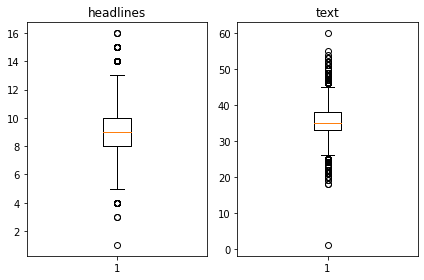

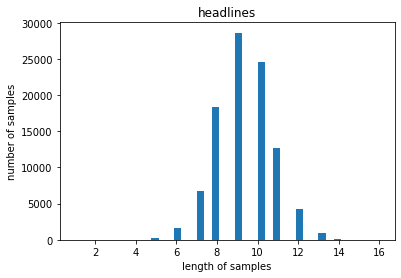

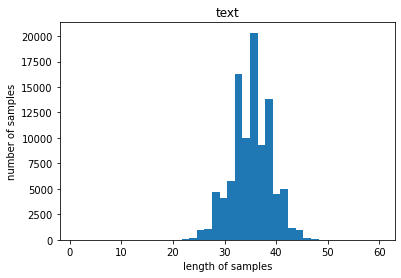

In [16]:
# 길이 분포 확인
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준편차 : {}'.format(np.std(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))
print('요약의 표준편차 : {}'.format(np.std(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# 최대 길이 (평균 + 표준편차 * 2)
text_max_len = int(np.mean(text_len) + np.std(text_len) * 2)
summary_max_len = int(np.mean(summary_len) + np.std(summary_len) * 2)

print(text_max_len, summary_max_len)

42 12


In [18]:
# 데이터의 몇 %의 해당하는지 계산
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

# 정해진 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571
전체 샘플수 : 94754


In [19]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [20]:
# numpy로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
# 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[51057 48251 89938 ... 68196 76480 19087]


In [22]:
encoder_input[0]

'fire broke sets two tv serials cinevista studios mumbai saturday evening eight fire tenders spot report casualty far incident comes days fire claimed lives kamala mills compound area mumbai'

In [23]:
# 8:2 로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

테스트 데이터의 수 : 18950
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


In [24]:
# Keras의 Tokenizer 사용
# text 데이터 Tokenize
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [26]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67863
등장 빈도가 6번 이하인 희귀 단어의 수: 46156
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21707
단어 집합에서 희귀 단어의 비율: 68.01349778229668
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.537319274204069


In [27]:
# 집합 크기 제한
src_vocab = 21000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[284, 726, 1663, 11, 714, 10482, 5801, 74, 88, 2788, 363, 284, 6032, 806, 143, 13022, 656, 144, 61, 122, 284, 40, 964, 8905, 7262, 5689, 443, 74], [15002, 5551, 834, 1681, 15606, 123, 507, 4301, 6102, 100, 3029, 391, 5551, 1188, 1247, 828, 780, 1189, 1837, 419, 4891, 1726, 12621, 5551, 3891, 100, 524, 2359, 81, 1727, 17971], [9, 3673, 37, 534, 4977, 11, 482, 5626, 19020, 4332, 231, 351, 5506, 3122, 6858, 5858, 707, 524, 76, 3405, 16297, 87, 5627, 1224, 1353, 19021, 1698, 3123]]


In [29]:
# headlines 데이터 Tokenize
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [31]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29580
등장 빈도가 3번 이하인 희귀 단어의 수: 16676
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12904
단어 집합에서 희귀 단어의 비율: 56.375929682217716
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2461156133489313


In [32]:
# 집합 크기 제한
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 193, 449, 53, 7, 381, 6, 318, 3681, 45, 7486, 1737], [1, 10229, 5765, 255, 3, 1912, 3, 6045, 5521, 326], [1, 3482, 47, 7087, 929, 132], [1, 60, 340, 355, 175, 711, 439, 51, 4, 52], [1, 15, 91, 1974, 472, 8, 30, 715, 1457, 601, 1653]]
target
decoder  [[193, 449, 53, 7, 381, 6, 318, 3681, 45, 7486, 1737, 2], [10229, 5765, 255, 3, 1912, 3, 6045, 5521, 326, 2], [3482, 47, 7087, 929, 132, 2], [60, 340, 355, 175, 711, 439, 51, 4, 52, 2], [15, 91, 1974, 472, 8, 30, 715, 1457, 601, 1653, 2]]


In [34]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [35]:
# padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [36]:
# 모델 설계하기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7f76ff3df8e0>)

In [37]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [41]:
# 어텐션 층(어텐션 함수)
#attn_layer = AttentionLayer(name='attention_layer')
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [43]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [44]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
297/297 [==============================] - 211s 651ms/step - loss: 5.7673 - val_loss: 5.3505
Epoch 2/50
297/297 [==============================] - 190s 640ms/step - loss: 5.2011 - val_loss: 4.9791
Epoch 3/50
297/297 [==============================] - 190s 638ms/step - loss: 4.8553 - val_loss: 4.7477
Epoch 4/50
297/297 [==============================] - 190s 639ms/step - loss: 4.3786 - val_loss: 4.3808
Epoch 6/50
297/297 [==============================] - 189s 638ms/step - loss: 4.2094 - val_loss: 4.2801
Epoch 7/50
297/297 [==============================] - 190s 639ms/step - loss: 4.0648 - val_loss: 4.1813
Epoch 8/50
297/297 [==============================] - 189s 638ms/step - loss: 3.9405 - val_loss: 4.1068
Epoch 9/50
297/297 [==============================] - 190s 640ms/step - loss: 3.8303 - val_loss: 4.0465
Epoch 10/50
297/297 [==============================] - 190s 639ms/step - loss: 3.7313 - val_loss: 3.9912
Epoch 11/50
297/297 [==============================] - 190s 640

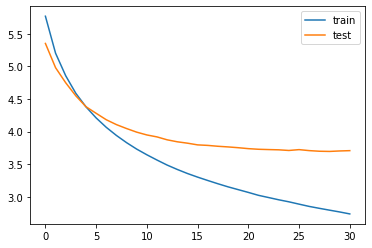

In [45]:
# 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [59]:
# 인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [61]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])


# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [62]:
# 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [64]:
# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [65]:
# 결과 비교
for i in range(50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : video shows fans american baseball team houston working together return woman hat fell seven floors parking lot fans tossed hat one floor time reached woman incident took place world series victory parade united states houston 
실제 요약 : fans throw woman hat from floor to floor to return it 
예측 요약 :  video shows baseball player with helicopter runs in england


원문 : song sexy barbie girl arbaaz khan sunny leone starrer tera cleared delhi high court word barbie replaced baby film makers sued inc manufacturer barbie dolls using word barbie song without company permission 
실제 요약 : sexy barbie girl song cleared after barbie changed to baby 
예측 요약 :  sunny leone starrer sunny deol starrer raazi


원문 : telugu actor comedian vijay sai found hanging residence hyderabad monday morning reports claimed actor committed suicide police yet confirm also reported vijay wife staying separately last one year actor treated depression 
실제 요약 : telugu actor vijay found dead suicide suspected 
예측 요약 :  t

예측 요약 :  video shows north korean president photo with kim jong un


원문 : rajasthan high court acquitted woman accused murdering child grounds suffering triggered stress syndrome time crime kumari chandra accused pushing three children two boys girl well august killing one boy 
실제 요약 : rajasthan hc clears woman who killed boy while due to pms 
예측 요약 :  rajasthan woman found guilty of killing woman in rajasthan


원문 : widening scope probe billion pnb fraud cbi questioning senior officers indian banks agency reportedly questioned general managers deputy general managers allahabad bank axis bank bank india whose overseas branches issued fraudulent guarantees pnb five bank officers questioned far 
실제 요약 : cbi questions other banks senior executives in pnb fraud 
예측 요약 :  banks are not fraud fraud accused pnb fraud case


원문 : indian spinner ravichandran ashwin revealed virender sehwag hit harbhajan singh sixes game rohtak fever ashwin added sehwag consider spinners bowlers found easy playi

예측 요약 :  bumrah once bowled out of him to dismiss bumrah


원문 : punjab national bank saturday said department financial services report ranked best state owned bank terms digital transactions bank fully committed digital india initiative pnb said statement rated sixth best overall category amongst banks india digital performance 
실제 요약 : govt ranks pnb as best state run bank for digital transactions 
예측 요약 :  pnb to merge with world bank for pnb fraud


원문 : three african women man arrested narcotics control bureau allegedly trying smuggle kg drugs worth lakh three separate operations arrested indira gandhi international airport trying fly foreign destinations drugs concealed bags official said 
실제 요약 : foreign nationals held with drugs worth lakh in delhi 
예측 요약 :  man arrested for smuggling kg of gold in mumbai


원문 : five time tamil nadu cm dmk chief karunanidhi passed away aged laid rest state honours chennai marina beach wednesday karunanidhi laid rest adjacent mausoleum mentor cn

In [ ]:
## 추출적 요약

In [66]:
import requests
from summa.summarizer import summarize

In [67]:
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [68]:
for i in range(50):
    print('원문     : {}'.format(summa_data['text'][i]))
    print('실제 요약 : {}'.format(summa_data['headlines'][i]))
    print('예측 요약 : {}'.format(summarize(summa_data['text'][i], words=15)))
    print('\n')

원문     : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문     : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of 

## 회고

#### 추상적 요약 기법의 경우
- 모두다 확인하지는 못했지만 어텐션을 이용하여 추상적 요약 기법으로 뉴스 기사를 요약한 경우를 보면 키워드는 어느정도 제대로 추출된 것 같음  
- 하지만 문장 구사가 무엇인가 어색하게 느껴짐(영문법에 정통한 것이 아니라 일반적으로 훑어 본 느낌)  
- 요약된 문장을 보면 실제적인 상황을 잘 요약한 것은 아니라는 판단이다. 무엇인가 애매한 느낌이다. 문맥의 일치도 정도가 매우 낮다고 본다.

#### 추출적 요약 기법의 경우  
- 뉴스 기사 속에 있는 문장을 추출하여 예측 결과로 내놓았기 때문에 추상적 요약 기법보다는 좀 덜 어색한 느낌이다.  
- 추상적 요약기법 보다는 문맥상의 일치도도 높다는 느낌이다.
- 그러나 요약결과가 출력되지 않는 문제가 확인된다. 이는 summa를 이용하여 summarize 하는 과정에서 문장의 길이가 주어진 ratio나 words보다 적은 경우에 발생하는 결과라고 생각된다.

- 각 레이어들 간의 관계와 어탠션에 대해서 조금 더 이해할 수 있었지만 아직 더 많은 공부가 필요한 것 같다. 

## 테스트 공간

In [ ]:
# 문장 전체가 똑같을 수 있는가? 있네..... 이놈들 무슨 생각으로 똑같은 문장을 복사 한거야.....

df = pd.DataFrame(["Virender Sehwag was captaining India when he hit 219 runs against Windies on December 8, 2011, becoming the second cricketer after Sachin Tendulkar to score a double hundred in ODIs. Sehwag's 219(149) is the highest individual score by a captain in ODI cricket history. Sehwag's knock helped India pile up their highest ODI total of 418/5.", 2, "Virender Sehwag was captaining India when he hit 219 runs against Windies on December 8, 2011, becoming the second cricketer after Sachin Tendulkar to score a double hundred in ODIs. Sehwag's 219(149) is the highest individual score by a captain in ODI cricket history. Sehwag's knock helped India pile up their highest ODI total of 418/5.", 4, 3, 2, 1, "Virender Sehwag was captaining India when he hit 219 runs against Windies on December 8, 2011, becoming the second cricketer after Sachin Tendulkar to score a double hundred in ODIs. Sehwag's 219(149) is the highest individual score by a captain in ODI cricket history. Sehwag's knock helped India pile up their highest ODI total of 418/5.", 5, 8, 8, 5, 0, 2, 4, 3, 6, 8, 11, 3, 4, 22, 5,4, 65, 4, 5])
df.value_counts()